# STOR 566, Homework 3
### Instructor: Yao Li
### Keywords: LSTM, SST2
### Due date: Oct 02, 11:55pm
### **Submission Instruction**

- Please download this script and use it to answer the questions in the homework. 
- For submission, please include your code, code output and answers in the script and submit the ipynb file on sakai.
- Please don't modify existing cells. But you can add cells between the exercise statements.
- To make markdown, please switch the cell type to markdown (from code) - you can hit 'm' when you are in command mode - and use the markdown language. For a brief tutorial see: https://daringfireball.net/projects/markdown/syntax

### **References:**

- You can follow the setup instructions at [here](https://pytorch.org/get-started/locally/).
- A useful tutorial on learning pytorch by examples at [here](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html).
- Check Pytorch optimization methods at [here](https://pytorch.org/docs/stable/optim.html).
- Check Torchtext tutorial at [here](https://pytorch.org/text/stable/tutorials/sst2_classification_non_distributed.html).


### **Evaluation Metrics of Classifiers:**

- Average Test Loss (based on the test set): 
    \begin{align}
	  \frac{1}{B}\sum_{b=1}^B {\text loss}_b
	  \end{align}
    
    - $B$: the total number of batches from the test set
    - loss$_b$: the loss of $b$-th batch
    - Note: loss$_b$=criteria(output, target), where criteria is the loss function you use.

- Testing accuracy: 
	\begin{align}
	\frac{1}{N}\sum_{i=1}^N {\bf 1}(\hat{y}_i=y_i)
	\end{align}	
    - $N$: the total number of samples in the testing set
    - $y_i$: true label of sample $i$
    - $\hat{y}_i$: predicted label by the model

## Problem 1 (100 points)

In this problem you will practice implementing LSTM on SST2 data set to do sentiment analysis (binary classification of positive vs. negative).

**Data.** You will use SST2 dataset. Pytorch/torchdata has provide a useful dataloader to automatically download and load the data into batches. In this homework, you need two class, positive and negative, for binary classification. Code of the data loader has been provided in the template. You can modify the data loading part to use different tokenizer.

In [ ]:
'''
# You need package torchdata for this homework
# To avoid loading it every time, you can install torchdata to a path on google drive
import os
from google.colab import drive
drive.mount('/content/drive')
pkg_path = '/content/drive/MyDrive/DIR_FOR_PKGS'
!pip install --target=$pkg_path torchdata

# Append the path to the sys path to load the pkg without re-installation
import sys
pkg_path = '/content/drive/MyDrive/DIR_FOR_PKGS'
sys.path.append(pkg_path)
import torchdata
'''

In [1]:
# Mount your drive
import os
import sys
from google.colab import drive
drive.mount('/content/drive')
pkg_path = '/content/drive/MyDrive/DIR_FOR_PKGS' #Please specify the path where you installed torchdata
sys.path.append(pkg_path)

Mounted at /content/drive


In [2]:
# Package Loading
# Feel free to add pakcages
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import torchdata
import torch
import torch.nn as nn
import torchtext.transforms as T
import torchtext.functional as F
from torchtext.datasets import SST2
from torch.utils.data import DataLoader
from torch.hub import load_state_dict_from_url
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
# Prepare data loader
# Feel free to modify the data loading process as needed
padding_idx = 1
bos_idx = 0
eos_idx = 2
batch_size = 16
max_seq_len = 256
# You can use other Tokenizer
xlmr_vocab_path = r"https://download.pytorch.org/models/text/xlmr.vocab.pt"
xlmr_spm_model_path = r"https://download.pytorch.org/models/text/xlmr.sentencepiece.bpe.model"
xmlr_vocab = load_state_dict_from_url(xlmr_vocab_path)

text_transform = T.Sequential(
    T.SentencePieceTokenizer(xlmr_spm_model_path),
    T.VocabTransform(xmlr_vocab),
    T.Truncate(max_seq_len - 2),
    T.AddToken(token=bos_idx, begin=True),
    T.AddToken(token=eos_idx, begin=False),
)

train_datapipe = SST2(split="train")
test_datapipe = SST2(split="dev")

def apply_transform(x):
    return text_transform(x[0]), x[1]

train_datapipe = train_datapipe.map(apply_transform)
train_datapipe = train_datapipe.batch(batch_size)
train_datapipe = train_datapipe.rows2columnar(["token_ids", "target"])
train_dataloader = DataLoader(train_datapipe, batch_size=None)

test_datapipe = test_datapipe.map(apply_transform)
test_datapipe = test_datapipe.batch(batch_size)
test_datapipe = test_datapipe.rows2columnar(["token_ids", "target"])
test_dataloader = DataLoader(test_datapipe, batch_size=None)

Downloading: "https://download.pytorch.org/models/text/xlmr.vocab.pt" to /root/.cache/torch/hub/checkpoints/xlmr.vocab.pt


  0%|          | 0.00/4.85M [00:00<?, ?B/s]

100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 5.07M/5.07M [00:00<00:00, 58.1MB/s]


### **Problem Description.** Implement **LSTM** with Pytorch to do binary classification.

### (a) (15 points) Print the model architecture.

In [ ]:
## Code:

In [4]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, vocab_size):
        super(LSTM, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state

        self.embedding = nn.Embedding(vocab_size, input_size)
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.drop = nn.Dropout(p=0.5)
        self.fc = nn.Linear(hidden_size, num_classes) #fully connected last layer
    
    def forward(self,x):
        embedding = self.embedding(x)
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(embedding, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.drop(hn)
        out = self.fc(out) #Final Output
        out = torch.squeeze(out, 1)
        out = torch.sigmoid(out)
        return out

In [5]:
LSTM(num_classes=1, input_size=768, hidden_size=128, num_layers=1, vocab_size=250002)

LSTM(
  (embedding): Embedding(250002, 768)
  (lstm): LSTM(768, 128, batch_first=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

### (b) (10 points) Report the hyper-parameters (number of epochs, learning rate, momentum, weight_decay etc).

Answer:

number of epochs: 10 <br>
learning rate = 1e-03 <br>
betas = (0.9, 0.999) <br>
eps = 1e-08 <br>
weight_decay = 1e-03

### (c) (60 points) Report the **Average Test Loss** after every training epoch by generating Average Test Loss vs. Epoch plot. Please report at least **10** epochs. Note that **Average Test Loss** is based on the test set.


In [ ]:
## Code:

In [9]:
num_epochs = 10
criterion = nn.BCELoss(weight=None, size_average=None, reduce=None, reduction='mean')
model = LSTM(num_classes=1, input_size=768, hidden_size=128, num_layers=1, vocab_size=250002).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-03, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-03)

epoch_loss = []
model.train()
for epoch in range(num_epochs):
    i = 0
    total_loss = 0
    run = 0
    correct = 0
    total = 0
    for batch in train_dataloader:
        input = F.to_tensor(batch["token_ids"], padding_value=padding_idx).to(device=device)
        target = torch.tensor(batch["target"]).to(device=device, dtype=torch.float)

        outputs = model(input)
        loss = criterion(outputs, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        i += 1
#         if i%100 == 0:
#            print("Iteration = [{} / 4210], loss = {}".format(i, loss.item()))
    
#     print("Batches end.")

    model.eval()
    for test in test_dataloader:
        testinput = F.to_tensor(test["token_ids"], padding_value=padding_idx).to(device=device)
        testtarget = torch.tensor(test["target"]).to(device=device, dtype=torch.float)

        testoutputs = model(testinput)
        testloss = criterion(testoutputs, testtarget)

        predicted = testoutputs.round().detach().numpy()
        total += testtarget.size(0)
        correct += np.sum((predicted == testtarget.detach().numpy()))

        total_loss += testloss.item()
        run += 1
    
    epoch_loss.append(total_loss/run)
    print("Epoch = [{}], loss = {}".format(epoch + 1, total_loss / run))

accuracy = 100 * correct / total

Epoch = [1], loss = 0.6974681269038807
Epoch = [2], loss = 0.6972143449783326
Epoch = [3], loss = 0.6968804495117881
Epoch = [4], loss = 0.6967130894227461
Epoch = [5], loss = 0.6950220299200578
Epoch = [6], loss = 0.6947579866322604
Epoch = [7], loss = 0.6971169160496105
Epoch = [8], loss = 0.7005228820714083
Epoch = [9], loss = 0.699811110756614
Epoch = [10], loss = 0.6978847605531866


In [ ]:
## Plot:

Text(0.5, 1.0, 'Average Loss of Every Epoch')

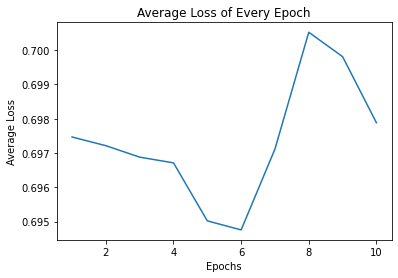

In [10]:
plt.plot(range(1,11), epoch_loss)
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.title('Average Loss of Every Epoch')

### (d) (15 points) Report the final testing accuracy of trained model.

Answer:

The final testing accuracy of trained model is 50.9%.

The training process takes very long time, somewhat indicating the model is hard to train. In addition, the relatively small accuracy implies the model is not trained very well. From the loss plot, we can find that the average losses are nearly the same for 10 epochs, which means that the model does not change a lot after 10 epochs. During the training process, the loss fluctuates between 0.5 to 0.8 (mostly around 0.7). After 4 epochs, generally, the trained loss steadily modestly increases maybe because of the overfitting.

The testing accuracies for 10 epochs are all around 50%, but in the training batch, the accuracy reaches up to about 65%, which means the model seems acceptable for some specific training batch, but not acceptable for the whole testing dataset.

In [11]:
accuracy

50.91743119266055